In [1]:
import cv2
import numpy as np
import os

# Load the main image
main_image_path = '1.jpg'
main_image = cv2.imread(main_image_path)

# List of item images
item_images = [f'items_list/item{i}.jpg' for i in range(1, 16)]  # Assuming images are named as item1.png, item2.png, etc.

# Create a directory to save the masks if it doesn't exist
mask_output_dir = 'item_masks'
os.makedirs(mask_output_dir, exist_ok=True)

# Loop through each item and save the mask for the first scale (1.0)
for idx, item_image_path in enumerate(item_images, 1):
    item_image = cv2.imread(item_image_path, cv2.IMREAD_UNCHANGED)  # Load with alpha channel if available
    
    # Create a mask where white (background) pixels are set to 0 (ignore) and others are set to 1
    gray_item = cv2.cvtColor(item_image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray_item, 240, 255, cv2.THRESH_BINARY_INV)  # Adjust threshold if necessary

    # Save the mask as an image for visualization
    mask_output_path = os.path.join(mask_output_dir, f'item{idx}_mask.png')
    cv2.imwrite(mask_output_path, mask)
    print(f'Mask for item{idx} saved to {mask_output_path}')


Mask for item1 saved to item_masks\item1_mask.png
Mask for item2 saved to item_masks\item2_mask.png
Mask for item3 saved to item_masks\item3_mask.png
Mask for item4 saved to item_masks\item4_mask.png
Mask for item5 saved to item_masks\item5_mask.png
Mask for item6 saved to item_masks\item6_mask.png
Mask for item7 saved to item_masks\item7_mask.png
Mask for item8 saved to item_masks\item8_mask.png
Mask for item9 saved to item_masks\item9_mask.png
Mask for item10 saved to item_masks\item10_mask.png
Mask for item11 saved to item_masks\item11_mask.png
Mask for item12 saved to item_masks\item12_mask.png
Mask for item13 saved to item_masks\item13_mask.png
Mask for item14 saved to item_masks\item14_mask.png
Mask for item15 saved to item_masks\item15_mask.png


# Codes below this are for testings, maybe they got wrong after i fixed them or kind of.

In [7]:
def matching(a,b, output_path):
# Load the main image
    main_image_path = '1.jpg'
    image = cv2.imread(main_image_path)
    main_image = image.copy()

    # List of items
    item_images = [f'items_list/item{i}.jpg' for i in range(a, b+1)]

    # Scaling size for items
    scales = np.arange(0.5, 2.25, 0.25)

    # Loop and perform template matching
    for item_image_path in item_images:
        item_image = cv2.imread(item_image_path, cv2.IMREAD_UNCHANGED)  # Load with alpha channel if available
        
        # Create mask for the item, set the parts that are white (the back ground) to 0
        gray_item = cv2.cvtColor(item_image, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray_item, 250, 255, cv2.THRESH_BINARY_INV)

        # Template matching
        for scale in scales:
            # Resize the item
            resized_item = cv2.resize(item_image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR_EXACT)
            resized_mask = cv2.resize(mask, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR_EXACT)

            # Template matching using mask
            #result = cv2.matchTemplate(image, resized_item, cv2.TM_CCOEFF_NORMED)
            result = cv2.matchTemplate(image, resized_item, cv2.TM_CCOEFF_NORMED, mask=resized_mask)
            threshold = 0.6
            locations = np.where(result >= threshold)

            # Draw rectangles around matched regions
            for pt in zip(*locations[::-1]):  # Switch x and y coordinates
                # Draw rectangle on the main image
                cv2.rectangle(
                    main_image, 
                    pt, 
                    (pt[0] + resized_item.shape[1], pt[1] + resized_item.shape[0]), 
                    (0, 255, 0), 
                    2
                )

    # Save or display the output image with highlighted items
    cv2.imwrite(output_path, main_image)

    print(f'Detected items saved to {output_path}')


matching(1,3, "p1_item123.jpg")

Detected items saved to p1_item123.jpg


Result for item 1 saved to find_rgb/find_1.jpg


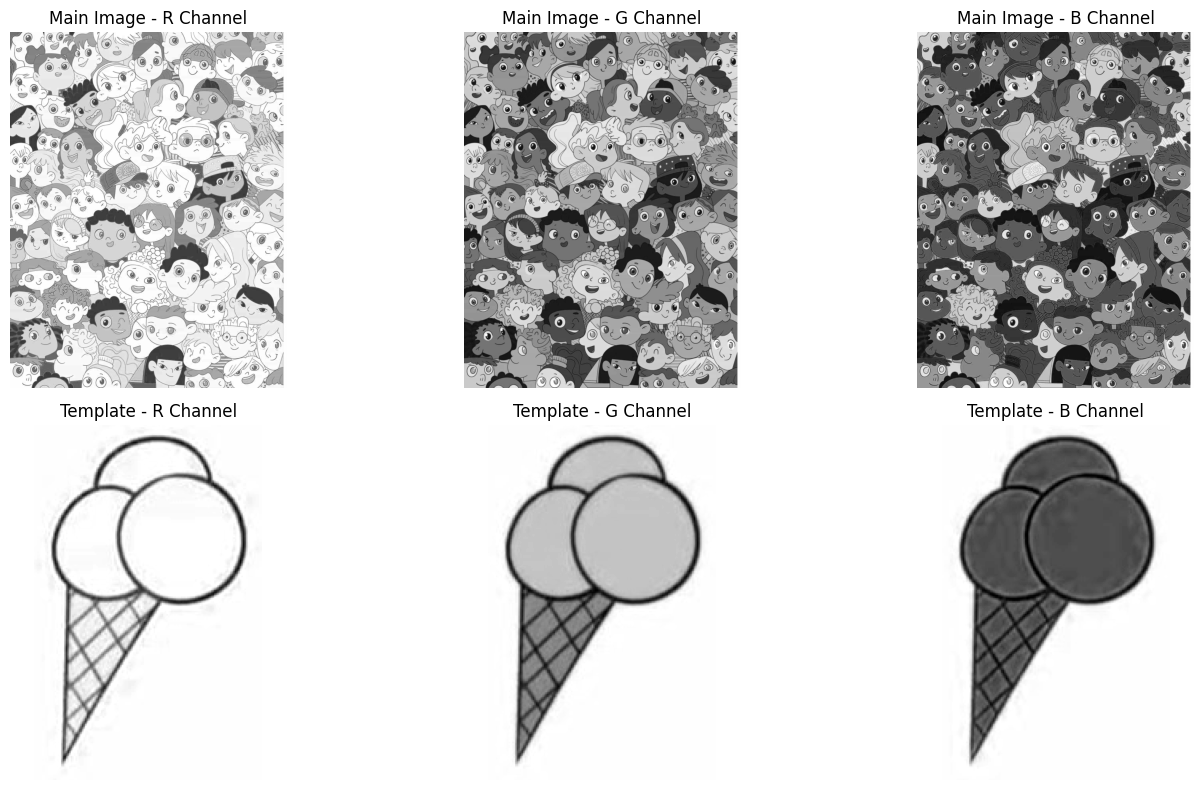

In [4]:
import cv2 as cv
import numpy as np
import os
from matplotlib import pyplot as plt


def matching_rgb(item_no, output_image_path, thresh = 0.8):
    # Define the paths for the main image and the template
    main_image_path = '1.jpg'
    item_image_path = f'items_list/item{item_no}.jpg'  # Assuming items are named as item1.png, item2.png, etc.
    
    # Load the main image and convert it to grayscale
    img_rgb = cv.imread(main_image_path)
    assert img_rgb is not None, "Main image could not be read, check the path."
    img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
    
    # Load the template (item) image
    template = cv.imread(item_image_path, cv.IMREAD_UNCHANGED)
    assert template is not None, f"Item image 'item{item_no}.jpg' could not be read, check the path."
    
    # Create a mask using thresholding to focus on non-white areas
    #_, mask = cv.threshold(gray_item, 220, 255, cv.THRESH_BINARY_INV)
    mask = np.any(template <= 250, axis=2).astype(np.uint8) * 255


    # Find the bounding box of the non-zero mask region
    non_zero_y, non_zero_x = np.nonzero(mask)
    top_left_y, bottom_right_y = np.min(non_zero_y), np.max(non_zero_y)
    top_left_x, bottom_right_x = np.min(non_zero_x), np.max(non_zero_x)

    # Crop the template and the mask to this bounding box
    cropped_template = template[top_left_y:bottom_right_y + 1, top_left_x:bottom_right_x + 1]
    cropped_mask = mask[top_left_y:bottom_right_y + 1, top_left_x:bottom_right_x + 1]

    # Split the main image and cropped template into R, G, B channels
    img_b, img_g, img_r = cv.split(img_rgb)
    template_b, template_g, template_r = cv.split(cropped_template)

    # Define the scales to search through
    scales = [1]

    # Iterate through each scale and find all matches
    for scale in scales:
        # Resize the cropped template and mask according to the current scale
        scaled_template_r = cv.resize(template_r, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
        scaled_template_g = cv.resize(template_g, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
        scaled_template_b = cv.resize(template_b, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
        scaled_mask = cv.resize(cropped_mask, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_NEAREST)

        # Skip if the scaled template is larger than the main image
        if scaled_template_r.shape[0] > img_b.shape[0] or scaled_template_r.shape[1] > img_b.shape[1]:
            continue

        # Perform template matching separately for each channel
        res_r = cv.matchTemplate(img_r, scaled_template_r, cv.TM_CCOEFF_NORMED, mask=scaled_mask)
        res_g = cv.matchTemplate(img_g, scaled_template_g, cv.TM_CCOEFF_NORMED, mask=scaled_mask)
        res_b = cv.matchTemplate(img_b, scaled_template_b, cv.TM_CCOEFF_NORMED, mask=scaled_mask)
        
        # Thresholding to find regions where all three match results exceed the threshold
        threshold = 0.8
        loc = np.where((res_r >= threshold) & (res_g >= threshold) & (res_b >= threshold))
    
        # Draw rectangles around detected regions
        for pt in zip(*loc[::-1]):
            cv.rectangle(img_rgb, pt, (pt[0] + scaled_mask.shape[1], pt[1] + scaled_mask.shape[0]), (0, 0, 255), 2)
    
    # Save the result image with highlighted matches
    output_image_path = "find_rgb/" + output_image_path + ".jpg"
    cv.imwrite(output_image_path, img_rgb)
    print(f"Result for item {item_no} saved to {output_image_path}")

    # Display the channels side by side
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    
    # Display R, G, B channels of the main image
    axs[0, 0].imshow(img_r, cmap='gray')
    axs[0, 0].set_title('Main Image - R Channel')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(img_g, cmap='gray')
    axs[0, 1].set_title('Main Image - G Channel')
    axs[0, 1].axis('off')

    axs[0, 2].imshow(img_b, cmap='gray')
    axs[0, 2].set_title('Main Image - B Channel')
    axs[0, 2].axis('off')
    
    # Display R, G, B channels of the cropped template
    axs[1, 0].imshow(template_r, cmap='gray')
    axs[1, 0].set_title('Template - R Channel')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(template_g, cmap='gray')
    axs[1, 1].set_title('Template - G Channel')
    axs[1, 1].axis('off')

    axs[1, 2].imshow(template_b, cmap='gray')
    axs[1, 2].set_title('Template - B Channel')
    axs[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
matching_rgb(1, 'find_1') 
